# Histogrammar and Functional Programming HATS

Last week, John and Mauro introduced PyROOT and rootpy, two Python interfaces to ROOT. Along the way, they showed some of the advantages of using a high-level scripting language for data analysis.

In this tutorial, I'll be presenting Histogrammar first as a way to speed up a PyROOT analysis (John's in particular) without leaving Python, then as a general introduction to functional programming for data analysis.

# Introduction: PyROOT acceleration

No programming language is good at everything. John showed you how Python simplifies the organizational part of a data analysis, but for heavy number crunching, C++ is much faster. This is widely acknowledged: the Scientific Python ecosystem (which I'll be showing tomorrow) is mostly written in C++ with Pythonic bindings.

John's recommendation is a good one:

   * use C++ for a focused, fast routine that does one thing in a streamlined way, and
   * use Python for everything else, gluing together the different parts of your analysis.

His example used MakeClass to build a C++ iterator over TTrees, and he controlled that iterator from Python. But as you saw, generating an iterator with MakeClass, compiling it, and switching between C++ and Python is cumbersome.

To motivate Histogrammar, let's see how it simplifies this bridge by letting you inject little C++ snippets in the midst of Python, for the sake of filling histograms quickly.

First, we import ROOT as before.

In [1]:
import time
import ROOT
tcanvas = ROOT.TCanvas("TCanvasName", "TCanvasTitle", 800, 300)

Welcome to JupyROOT 6.08/04


Now let's get some of John's data. We could access this directly in PyROOT using the "root://" file URLs, but we'll be focusing on performance and I found that performance numbers are more stable when you don't mix in network bandwidth.

These files add up to 220 MB; shouldn't break your quota. If you re-run this cell, `xrdcp` will complain that the file is already there (which is fine).

In [2]:
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_0.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_1.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_2.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_3.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_4.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_5.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_6.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_7.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_8.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_9.root .

[22.04MB/22.04MB][100%][==================================================][22.04MB/s]  
[22.09MB/22.09MB][100%][==================================================][22.09MB/s]  
[22.13MB/22.13MB][100%][==================================================][22.13MB/s]  
[22.1MB/22.1MB][100%][==================================================][22.1MB/s]  
[22.09MB/22.09MB][100%][==================================================][22.09MB/s]  
[22.08MB/22.08MB][100%][==================================================][22.08MB/s]  
[22.07MB/22.07MB][100%][==================================================][22.07MB/s]  
[22.11MB/22.11MB][100%][==================================================][22.11MB/s]  
[22.12MB/22.12MB][100%][==================================================][22.12MB/s]  
[22.15MB/22.15MB][100%][==================================================][22.15MB/s]  


Now we make a TChain of these files and take a quick look at their branches.

In [2]:
tchain = ROOT.TChain()
tchain.Add("sig_shuffled_0.root/tree")
tchain.Add("sig_shuffled_1.root/tree")
tchain.Add("sig_shuffled_2.root/tree")
tchain.Add("sig_shuffled_3.root/tree")
tchain.Add("sig_shuffled_4.root/tree")
tchain.Add("sig_shuffled_5.root/tree")
tchain.Add("sig_shuffled_6.root/tree")
tchain.Add("sig_shuffled_7.root/tree")
tchain.Add("sig_shuffled_8.root/tree")
tchain.Add("sig_shuffled_9.root/tree")
list(tchain.GetListOfBranches())

[<ROOT.TBranch object ("ph_N") at 0x5cb8ad0>,
 <ROOT.TBranchElement object ("ph_pdgId") at 0x5cc34f0>,
 <ROOT.TBranchElement object ("ph_charge") at 0x5ccb650>,
 <ROOT.TBranchElement object ("ph_e") at 0x5ccbd40>,
 <ROOT.TBranchElement object ("ph_eta") at 0x5ccc430>,
 <ROOT.TBranchElement object ("ph_phi") at 0x5cccb20>,
 <ROOT.TBranchElement object ("ph_mass") at 0x5ccd210>,
 <ROOT.TBranchElement object ("ph_pt") at 0x5ccd900>,
 <ROOT.TBranchElement object ("ph_et") at 0x5ccdff0>,
 <ROOT.TBranchElement object ("ph_rho") at 0x5cce6e0>,
 <ROOT.TBranchElement object ("ph_superCluster_eta") at 0x5ccedd0>,
 <ROOT.TBranchElement object ("ph_superCluster_phi") at 0x5ccf580>,
 <ROOT.TBranchElement object ("ph_sigmaIetaIeta") at 0x5ccfd30>,
 <ROOT.TBranchElement object ("ph_hOverE") at 0x5cd04e0>,
 <ROOT.TBranchElement object ("ph_isoGamma") at 0x5cd0bd0>,
 <ROOT.TBranchElement object ("ph_isoCh") at 0x5cd12c0>,
 <ROOT.TBranchElement object ("ph_passEleVeto") at 0x5cd19b0>,
 <ROOT.TBranchElem

# This is Histogrammar

Let's start with a very simple histogram fill-and-plot using Histogrammar. The next cell shows a pedestrian example of iterating over the `tchain` (in Python: slow!) and filling the histogram using a conventional interface.

By "conventional interface," I mean there's a `fill()` method that you call in the `for` loop on each event.

In [6]:
from histogrammar import *

histogram = Bin(100, 0, 1000, lambda x: x)    # I'll explain this "lambda x: x" in a moment

startTime = time.time()
for event in tchain:
    if event.jetAK4_N > 0:
        histogram.fill(event.jetAK4_pt[0])
endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 24.045511961 seconds.


The Histogrammar library is completely independent of ROOT— it was originally developed for use in Apache Spark— but it is capable of dumping its data to ROOT.

In fact, Histogrammar has no visualization capabilities at all. It uses a variety of external libraries to draw its plots: ROOT, Matplotlib, and Bokeh (currently).

(With ROOT, you have to save the result as a `roothist` that doesn't get garbage collected, or else it will disappear soon after you draw it!)

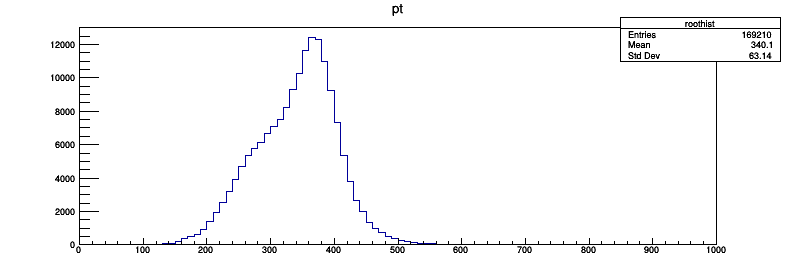

In [8]:
roothist = histogram.plot.root("roothist", "pt")
roothist.Draw()
tcanvas.Draw()

Internally, the Histogrammar histogram has its own representation, which is canonically expressed as JSON. There are several different language versions of Histogrammar, and they all speak the same JSON. That lets you exchange histograms made on different platforms.

In [10]:
histogram.toJson()

{'data': {'data': {'entries': 169210.0,
   'high': 1000.0,
   'low': 0.0,
   'name': 'jetAK4_pt[0]',
   'nanflow': 0.0,
   'nanflow:type': 'Count',
   'overflow': 0.0,
   'overflow:type': 'Count',
   'underflow': 0.0,
   'underflow:type': 'Count',
   'values': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    1.0,
    4.0,
    4.0,
    28.0,
    55.0,
    103.0,
    179.0,
    349.0,
    480.0,
    621.0,
    941.0,
    1391.0,
    1923.0,
    2546.0,
    3169.0,
    3890.0,
    4683.0,
    5330.0,
    5763.0,
    6107.0,
    6688.0,
    7085.0,
    7535.0,
    8247.0,
    9294.0,
    10282.0,
    11647.0,
    12418.0,
    12330.0,
    10984.0,
    9216.0,
    7341.0,
    5338.0,
    3819.0,
    2650.0,
    1980.0,
    1337.0,
    959.0,
    721.0,
    511.0,
    366.0,
    270.0,
    202.0,
    128.0,
    98.0,
    56.0,
    51.0,
    31.0,
    20.0,
    17.0,
    9.0,
    4.0,
    6.0,
    0.0,
    3.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    

Now to explain that "`lambda x: x`" in the histogram definition: although you _can_ use Histogrammar the same way you would use ROOT, it's intended to be used differently.

Instead of making histograms that don't know what they're going to be filled with, and then passing the right thing into their `fill()` functions, we should declare what a histogram is going to be filled with when it's created. This is called a fill rule.

In the example below, we define a histogram in two nested pieces:

   * `Select` only lets some events through, according to the rule "`event.jetAK4_N > 0`"
   * `Bin` is a 1D histogram, filled with "`event.jetAK4_pt[0]`".

Now all the analysis-specific information is in the histogram definition, right next to the bin-space definitions, and the `for` loop just calls `fill(event)`.

This took 27.5738108158 seconds.


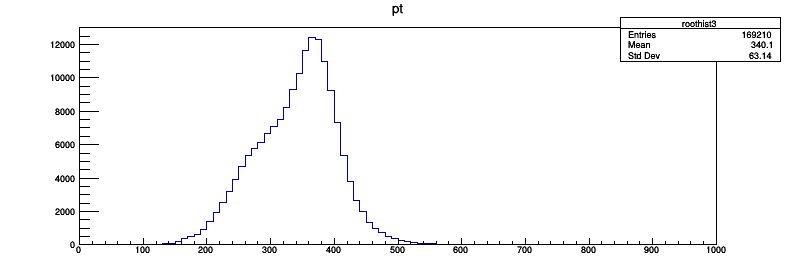

In [11]:
histogram = Select(lambda event: event.jetAK4_N > 0, Bin(100, 0, 1000, lambda event: event.jetAK4_pt[0]))

startTime = time.time()
for event in tchain:
    histogram.fill(event)
endTime = time.time()

print "This took", endTime - startTime, "seconds."

roothist3 = histogram.plot.root("roothist3", "pt")
roothist3.Draw()
tcanvas.Draw()

But, as I'm sure you're painfully aware, it takes close to 30 seconds each time you run through the events!

In addition to having different plotting front-ends, Histogrammar has different filling back-ends. We've been using generic Python filling, but if we replace the lambda functions with strings and fill with

```
histogram.fill.root(tchain)
```

then Histogrammar takes over the `for` loop and compiles it in C++. The strings are interpreted as C++ code, but they're short enough snippets that it's no problem to write.

The upshot is that exactly the same data can be aggregated 14 times faster.

This took 1.87890481949 seconds.


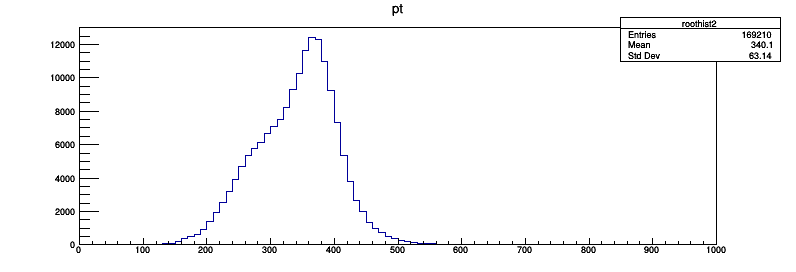

In [9]:
histogram = Select("jetAK4_N > 0", Bin(100, 0, 1000, "jetAK4_pt[0]"))

startTime = time.time()
histogram.fill.root(tchain)
endTime = time.time()

print "This took", endTime - startTime, "seconds."

roothist2 = histogram.plot.root("roothist2", "pt")
roothist2.Draw()
tcanvas.Draw()

This is within a factor of 4 of the speed you could achieve with `TTree::Draw`, but as we'll see below, Histogrammar is more versitile than `TTree::Draw`.

This took 0.515255212784 seconds.


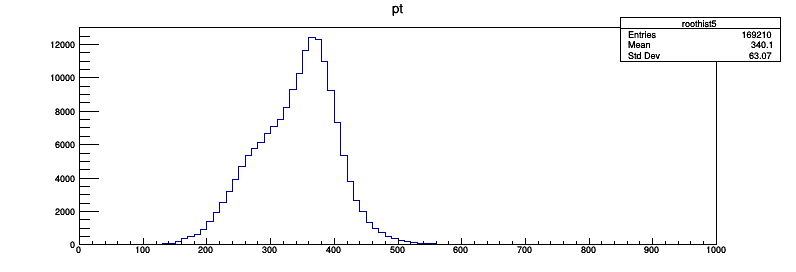

In [14]:
roothist5 = ROOT.TH1D("roothist5", "pt", 100, 0, 1000)

startTime = time.time()
tchain.Draw("jetAK4_pt[0] >> roothist5")
endTime = time.time()

print "This took", endTime - startTime, "seconds."
tcanvas.Draw()

# A complex example

John's code did more than just dump the TTree data into plots. It took two jets, computed the dijet mass, and boosted one of them to view an angle in the dijet Lorentz frame.

For a proper comparison, let's reproduce John's example in Python (no MakeClass).

In [4]:
tchain.SetBranchStatus("*", 0)
for branch in ["jetAK4_N",
               "jetAK4_pt",
               "jetAK4_eta",
               "jetAK4_mass",
               "jetAK4_phi",
               "jetAK4_e",
               "jetAK4_jec",
               "jetAK4_IDLoose"]:
    tchain.SetBranchStatus(branch, 1)

Below, we define three histograms (the ROOT way), create TLorentzVector objects outside the loop, and then do a Python `for` loop in which we compute dijets, boost the leading jet, and fill the histograms with some ratios.

In [5]:
dijetMass_hist = ROOT.TH1D("dijetMass_hist", "dijet mass [GeV]", 100, 0, 1000)
dijetEtBalance_hist = ROOT.TH1D("dijetEtBalance_hist", "dijet ET balance", 100, 0, 1)
cosThetaStar_hist = ROOT.TH1D("cosThetaStar_hist", "cos(theta*)", 100, -1, 1)

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for event in tchain:
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    dijet = leadingJet + subleadingJet

    boostedLeadingJet = leadingJet
    boostedLeadingJet.Boost(-dijet.BoostVector())
    
    dijetMass_hist.Fill(dijet.M())
    dijetEtBalance_hist.Fill(subleadingJet.Et() / leadingJet.Et())
    cosThetaStar_hist.Fill(boostedLeadingJet.Pz() / boostedLeadingJet.P())

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 21.2750182152 seconds.


They look nice.

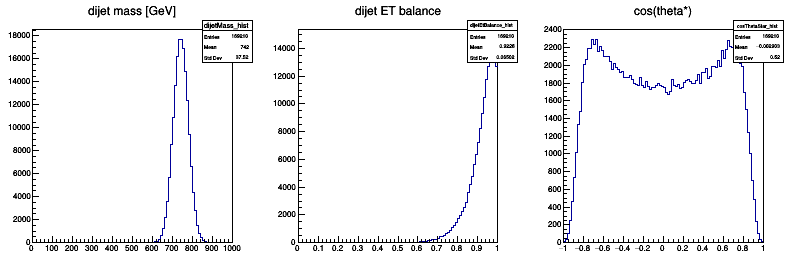

In [6]:
tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()

Now we do the same in Histogrammar (pure Python). We can bundle three histograms into a single histogram-like object with a single `fill()` method. This is where the fill-rules are showing a conceptual advantage: they keep the complete histogram definitions in one place, so that you can carry around the whole bundle and fill it generically in the loop.

All three histograms' fill rules operate on `[leadingJet, subleadingJet]` pairs.

In [7]:
Bundle = UntypedLabel    # a naming convention we'll be changing to in Histogrammar 2.0

def cosThetaStar(jets):
    boostedLeading = jets[0]
    boostedLeading.Boost(-(jets[0] + jets[1]).BoostVector())
    return boostedLeading.Pz() / boostedLeading.P()

histograms = Bundle(
    dijetMass      = Bin(100, 0, 1000, lambda jets: (jets[0] + jets[1]).M()),
    dijetEtBalance = Bin(100, 0, 1, lambda jets: jets[1].Et() / jets[0].Et()),
    cosThetaStar   = Bin(100, -1, 1, cosThetaStar))

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for event in tchain:
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    histograms.fill([leadingJet, subleadingJet])

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 34.4799318314 seconds.


But that's slow. It's even slower than the PyROOT example because _no_ parts of the histogram-filling were in compiled code. It had to navigate the bundle and each histogram's binning in pure Python.

Before moving on, let's make sure we see the same plots.

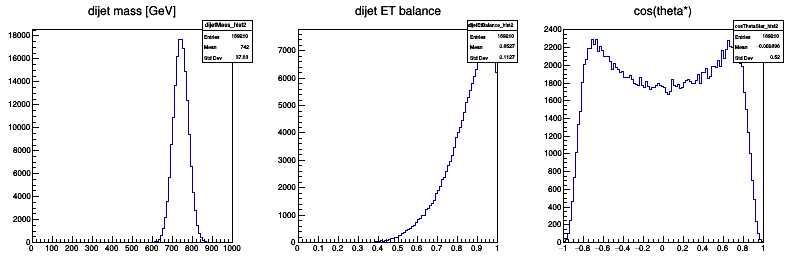

In [8]:
dijetMass_hist2      = histograms.get("dijetMass").plot.root("dijetMass_hist2", "dijet mass [GeV]")
dijetEtBalance_hist2 = histograms.get("dijetEtBalance").plot.root("dijetEtBalance_hist2", "dijet ET balance")
cosThetaStar_hist2   = histograms.get("cosThetaStar").plot.root("cosThetaStar_hist2", "cos(theta*)")

tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist2.Draw()
tcanvas.cd(2); dijetEtBalance_hist2.Draw()
tcanvas.cd(3); cosThetaStar_hist2.Draw()
tcanvas.Draw()

Yup, we do.

Okay, now to do a compiled version of the Histogrammar example. The tricky thing is that the operations we want to perform are too complicated for simple expressions, so we'll need some helper functions.

Since the code in quoted fill rules are C++, they need to be C++ functions. Fortunately, ROOT lets us define C++ functions from Python: use `ROOT.gInterpreter.Declare`.

In [9]:
# yes, we're creating new TLorentzVectors, but on the stack, which is faster than allocation with "new"
ROOT.gInterpreter.Declare("""
TLorentzVector lorentzVector(int i, vector<float>& pt, vector<float>& eta, vector<float>& phi, vector<float>& e) {
    TLorentzVector out;
    out.SetPtEtaPhiE(pt.at(i), eta.at(i), phi.at(i), e.at(i));
    return out;
}
""")

ROOT.gInterpreter.Declare("""
double cosThetaStar(TLorentzVector leadingJet, TLorentzVector subleadingJet) {
    leadingJet.Boost(-(leadingJet + subleadingJet).BoostVector());
    return leadingJet.Pz() / leadingJet.P();
}
""")

True

The variables available to the Histogrammar fill rules are the fields of the TTree, so this is what we have to pass in to our new `lorentzVector` function. We use C++ tricks (passing by reference with "`&`") to avoid unnecessary copies.

We're not freed from having to know C++ details, but we can put all of this together more quickly by not having to create and compile external files.

Here's what the accelerated Histogrammar code looks like. I'd argue that this is more concise and easier to read than even the PyROOT version.

In [10]:
histograms = Select("jetAK4_N >= 2", Bundle(
    dijetMass = Bin(100, 0, 1000, """
        (lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e) +
         lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e)
        ).M()
    """),
    dijetEtBalance = Bin(100, 0, 1, """
        lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e).Et() /
        lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e).Et()
    """),
    cosThetaStar   = Bin(100, -1, 1, """cosThetaStar(
        lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e),
        lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e))""")
))

startTime = time.time()
histograms.fill.root(tchain)
endTime = time.time()

print "This took", endTime - startTime, "seconds (including compilation)."

This took 1.86146497726 seconds (including compilation).


And it's fast! 11.4 times faster than the PyROOT version and 18.5 times faster than the pure Python Histogrammar version. We get the same plots:

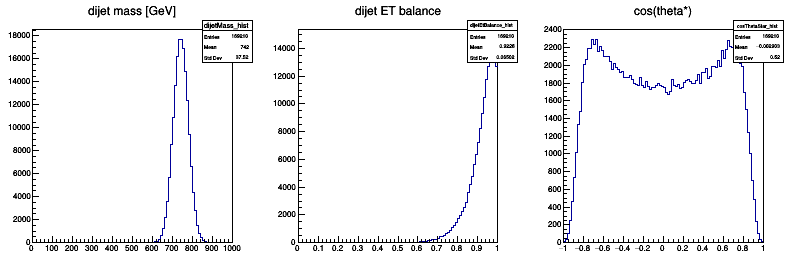

In [11]:
dijetMass_hist3      = histograms.get("dijetMass").plot.root("dijetMass_hist3", "dijet mass [GeV]")
dijetEtBalance_hist3 = histograms.get("dijetEtBalance").plot.root("dijetEtBalance_hist3", "dijet ET balance")
cosThetaStar_hist3   = histograms.get("cosThetaStar").plot.root("cosThetaStar_hist3", "cos(theta*)")

tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()

In fact, if we were to write a pure C++ ROOT macro that does the same thing, it's only 20% faster. (And it's not due to any of the seemingly obvious things, like the fact that the Histogrammar example above generates new `TLorentzVectors` for each histogram-fill: that stuff actually doesn't matter much if you avoid heap-allocation.)

With such a marginal gain, there's not much advantage to translating a script from Python to ROOT.

In [12]:
!root -l rootmacro.C++

root [0] 
Processing rootmacro.C++...
Info in <TUnixSystem::ACLiC>: creating shared library /uscms_data/d2/pivarski/CMSSW_9_0_1/src/scientific-python-hats/histogrammar/./rootmacro_C.so
This took 1.56078 seconds.


This concludes the introduction to Histogrammar and how it can speed up your PyROOT scripts.

In the next tutorial, after the break, I'll expand on the motivation: _why_ organize the histogram API with fill rules? What was that nesting of `Select` and `Bin` all about?

Histogrammar was designed to bring histogram-filling into the functional programming paradigm, which is the way many data analysis tools are headed because it leads the way to automatic parallelization.